In [7]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime
from datetime import timedelta

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [8]:
COUNTRIES_INCLUDED = ['Austria', 'Italy', 'Belgium', 'Latvia', 'Bulgaria', 'Lithuania', 'Croatia', 'Luxembourg', 
                     'Cyprus', 'Malta', 'Czechia', 'Netherlands', 'Denmark', 'Poland', 'Estonia', 'Portugal', 
                     'Finland', 'Romania', 'France', 'Slovakia', 'Germany', 'Slovenia', 'Greece', 'Spain', 
                     'Hungary', 'Sweden', 'Ireland', 'Russia', 'Norway', 'Switzerland',
                    'United_Kingdom', 'Belarus']

In [9]:
countries_onset = pd.read_csv('data/onset.csv',
                     parse_dates=['date'],dayfirst=False,
                     index_col=['country', 'date']).sort_index()

In [10]:
pdelay = pd.read_csv('data/pdelay.csv')['pdelay']

In [11]:
pdelay_cumsum = pdelay.values.cumsum()[::-1]

In [12]:
def pad_cumsum(n):
    ones_needed = np.max([n - len(pdelay_cumsum),0])
    padding_shape = (ones_needed, 0)
    return np.pad(pdelay_cumsum,padding_shape,constant_values=1.0)[-n:]

# Sample the posterior

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [40]:
class MCMCModel(object):
    
    def __init__(self, region, onset, window=1000):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_pdelay = pad_cumsum(self.onset.size)
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=2, tune=1000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Laplace('theta_raw_steps', mu=0, b=step_size, shape=len(self.onset)-2)
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=46.0, beta=10.0)
            r_t = pm.Deterministic('r_t', theta*serial_interval + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_pdelay[:-1]
            expected_today = inferred_yesterday * (self.cumulative_pdelay[1:]) * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.values[1:].flatten().round()
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self

In [41]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['country', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def create_and_run_model(name, country_onset):
    return MCMCModel(name, country_onset['Onset']).run(tune=3000)

In [48]:
quick_countries = ['Italy', 'France', 'Poland'] #, 'Italy', 'Austria', 'France', 'Germany', 'Spain', 'Netherlands', 'Belgium']
models = {}

In [49]:
for country, grp in countries_onset.groupby('country'):
    
    # TODO: fixup the data or automate skipping of countries with broken data
#     if country in ['Lithuania', 'Portugal']:
#         continue
    
    if quick_countries and not country in quick_countries:
        continue
    
    print(country)
    
    if country in models:
        print(f'Skipping {country}, already in cache')
        continue
    
    models[country] = create_and_run_model(country, grp.droplevel(0))

France


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [07:52<00:00, 16.95draws/s]
The number of effective samples is smaller than 25% for some parameters.


Italy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [08:44<00:00, 15.25draws/s] 
The number of effective samples is smaller than 25% for some parameters.


Poland


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [09:35<00:00, 13.90draws/s]  
The estimated number of effective samples is smaller than 200 for some parameters.


In [50]:
model = models['Italy']
df = df_from_model(model)
df

mean    median  lower_90  upper_90  lower_50  upper_50
country date                                                                  
Italy   2020-01-13  1.705104  1.687419  1.290609  2.076453  1.508340  1.800544
        2020-01-14  1.706916  1.691712  1.290049  2.060159  1.525289  1.816528
        2020-01-15  1.708093  1.691309  1.322393  2.084157  1.544453  1.831047
        2020-01-16  1.710262  1.695138  1.345045  2.100088  1.544108  1.827819
        2020-01-17  1.712545  1.696363  1.343212  2.097988  1.543578  1.829030
...                      ...       ...       ...       ...       ...       ...
        2020-05-19  0.888052  0.886545  0.731591  1.049735  0.817223  0.945827
        2020-05-20  0.890259  0.890939  0.707481  1.059018  0.832529  0.971344
        2020-05-21  0.891267  0.891121  0.696572  1.074659  0.834468  0.982178
        2020-05-22  0.891620  0.891162  0.675110  1.075034  0.829980  0.985410
        2020-05-23  0.892414  0.895065  0.690969  1.108208  0.825546  0.989543

[132 rows x 6 columns]

In [51]:
full_data = pd.concat([df_from_model(models[country]) for country in models])
full_data

mean    median  lower_90  upper_90  lower_50  upper_50
country date                                                                  
France  2020-01-23  1.676230  1.659259  1.253383  2.083502  1.496649  1.841672
        2020-01-24  1.679147  1.664283  1.274733  2.093324  1.408814  1.749580
        2020-01-25  1.680840  1.664366  1.291923  2.097854  1.438095  1.774048
        2020-01-26  1.685776  1.671595  1.312293  2.105268  1.509404  1.842075
        2020-01-27  1.689811  1.674230  1.316204  2.095031  1.481474  1.810684
...                      ...       ...       ...       ...       ...       ...
Poland  2020-05-19  1.075947  1.073001  0.891134  1.261099  1.002009  1.143723
        2020-05-20  1.075712  1.074804  0.878157  1.269534  1.008471  1.154015
        2020-05-21  1.075099  1.073226  0.862890  1.275182  1.001129  1.157867
        2020-05-22  1.075461  1.075268  0.872637  1.317031  0.984979  1.155663
        2020-05-23  1.075666  1.077563  0.854973  1.313882  1.000816  1.177899

[351 rows x 6 columns]

In [52]:
full_data.to_csv('data/rt_pymc3.csv')

In [54]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(0.0, 3.0)
    ax.set_title(name)
    ax.plot(result['median'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    ax.fill_between(
        result.index,
        result['lower_90'].values,
        result['upper_90'].values,
        color=ci,
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

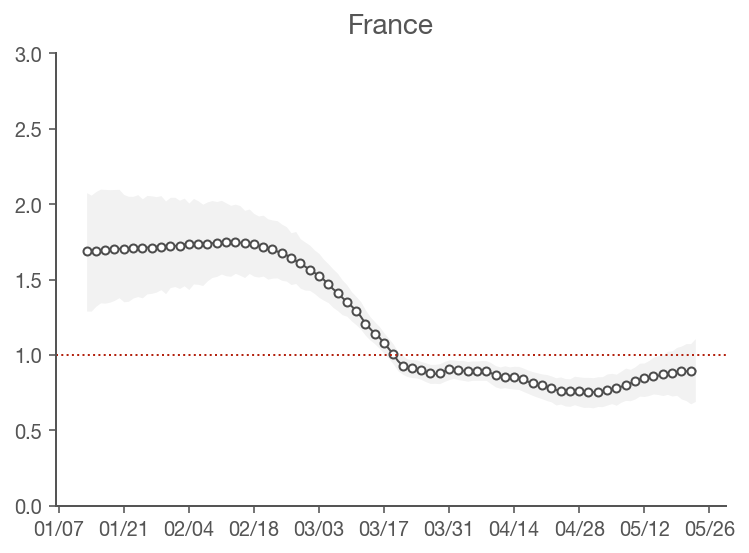

In [56]:
fig, axes = plt.subplots()
plot_rt('France', df.droplevel(0), axes)